# *📊 Employee Attrition - Feature Selection*

---

## *Author*  
**Kfir Tayar** 

## *Notebook Overview*  
- Split the Data Frame into X & y
- Scale the continuous features 
- fit the data on various models to determine the best features  
- Plot the voting sum 
- Choosing features by Threshold  
- Save the filtered file as a Pickle file

In [24]:
# Import Libraries & Modules
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge
import xgboost as xgb

# Add the path to the utils directory
sys.path.append(os.path.abspath('../utils'))

from data_prep_utils import save_file_as_pickle

### Load Data Set

In [3]:
encoded_df = pd.read_pickle("../data/encoded_employee_data_20250325.pkl")

In [4]:
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74498 entries, 0 to 74497
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Gender                    74498 non-null  int64  
 1   Years at Company          74498 non-null  int64  
 2   Monthly Income            74498 non-null  int64  
 3   Work-Life Balance         74498 non-null  int64  
 4   Job Satisfaction          74498 non-null  int64  
 5   Performance Rating        74498 non-null  int64  
 6   Number of Promotions      74498 non-null  int64  
 7   Overtime                  74498 non-null  bool   
 8   Distance from Home        74498 non-null  float64
 9   Education Level           74498 non-null  int64  
 10  Number of Dependents      74498 non-null  int64  
 11  Job Level                 74498 non-null  int64  
 12  Company Size              74498 non-null  int64  
 13  Remote Work               74498 non-null  bool   
 14  Leader

In [8]:
encoded_df.head()

,Gender,Years at Company,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,Overtime,Distance from Home,Education Level,...,avg time for promotion,Has Dependents,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Job Role_Education,Job Role_Finance,Job Role_Healthcare,Job Role_Media,Job Role_Technology
0,1,19,5390,0,2,0,2,True,35.405568,0,...,9.500000,0,False,True,False,True,False,False,False,False
1,0,4,5534,3,0,3,3,True,33.796224,3,...,1.333333,1,True,False,False,False,False,False,True,False
2,0,10,8159,2,0,3,0,True,17.702784,1,...,0.000000,1,False,True,False,False,False,True,False,False
3,0,7,3989,2,0,2,1,True,43.452288,2,...,7.000000,1,False,False,True,True,False,False,False,False
4,1,41,4821,1,3,0,0,True,114.263424,2,...,0.000000,0,True,False,False,True,False,False,False,False


### Scale the data

In [11]:
y = encoded_df['Attrition']
X = encoded_df.drop(columns=['Attrition'])

In [13]:
# List of continuous features
cols_to_scale = ['Years at Company', 'Monthly Income', 'Annual Income', 'Distance from Home', 'avg time for promotion']

# Initialize scaler
scaler = MinMaxScaler()

# Scale the features in the list
X_scaled = scaler.fit_transform(X[cols_to_scale])

# Convert back to DataFrame
scaled_X = pd.DataFrame(X_scaled, columns=cols_to_scale)

# Combine all the features to single Data Frame
X_final = pd.concat([scaled_X, X.drop(columns=cols_to_scale).reset_index(drop=True)], axis=1)

# Show results
X_final.head()

,Years at Company,Monthly Income,Annual Income,Distance from Home,avg time for promotion,Gender,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,...,At Least Decade,Has Dependents,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Job Role_Education,Job Role_Finance,Job Role_Healthcare,Job Role_Media,Job Role_Technology
0,0.36,0.279032,0.279032,0.214286,0.186275,1,0,2,0,2,...,True,0,False,True,False,True,False,False,False,False
1,0.06,0.288682,0.288682,0.204082,0.026144,0,3,0,3,3,...,False,1,True,False,False,False,False,False,True,False
2,0.18,0.464585,0.464585,0.102041,0.000000,0,2,0,3,0,...,True,1,False,True,False,False,False,True,False,False
3,0.12,0.185150,0.185150,0.265306,0.137255,0,2,0,2,1,...,False,1,False,False,True,True,False,False,False,False
4,0.80,0.240903,0.240903,0.714286,0.000000,1,1,3,0,0,...,True,0,True,False,False,True,False,False,False,False


In [15]:
# Fit Lasso model 
lasso = Lasso(alpha=5) 
lasso.fit(X_final, y)
lasso_selected = (np.abs(lasso.coef_) > 0).astype(int)

# Fit Ridge model 
ridge = Ridge(alpha=5)
ridge.fit(X_final, y)
ridge_selected = (np.abs(ridge.coef_) > 0).astype(int)

# Fit Gradient Boosting model
gb = GradientBoostingClassifier()
gb.fit(X_final, y)
gb_selected = (gb.feature_importances_ > 0).astype(int)

# Fit Logistic Regression model
logreg = LogisticRegression(penalty="l1", solver="liblinear", C=1)
logreg.fit(X_final, y)
logreg_selected = (np.abs(logreg.coef_).sum(axis=0) > 0).astype(int)

#Fit XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_final, y)
xgb_selected = (xgb_model.feature_importances_ > 0).astype(int)

# Create a DataFrame to store results
selection_df = pd.DataFrame({
    'Feature': X_final.columns,
    'Lasso': lasso_selected, 
    'Ridge': ridge_selected,
    'GradientBoost': gb_selected,
    'LogisticRegression': logreg_selected,
    'XGBoost': xgb_selected
})

# Sum the number of times a feature is selected
selection_df['Sum'] = selection_df.iloc[:, 1:].sum(axis=1)

# Sort by most selected features
selection_df = selection_df.sort_values(by='Sum', ascending=False)

# Output results
selection_df

,Feature,Lasso,Ridge,GradientBoost,LogisticRegression,XGBoost,Sum
0,Years at Company,0,1,1,1,1,4
25,Marital Status_Married,0,1,1,1,1,4
20,Age Group,0,1,1,1,1,4
19,Employee Recognition,0,1,1,1,1,4
18,Company Reputation,0,1,1,1,1,4
1,Monthly Income,0,1,1,1,1,4
14,Company Size,0,1,1,1,1,4
13,Job Level,0,1,1,1,1,4
12,Number of Dependents,0,1,1,1,1,4
11,Education Level,0,1,1,1,1,4


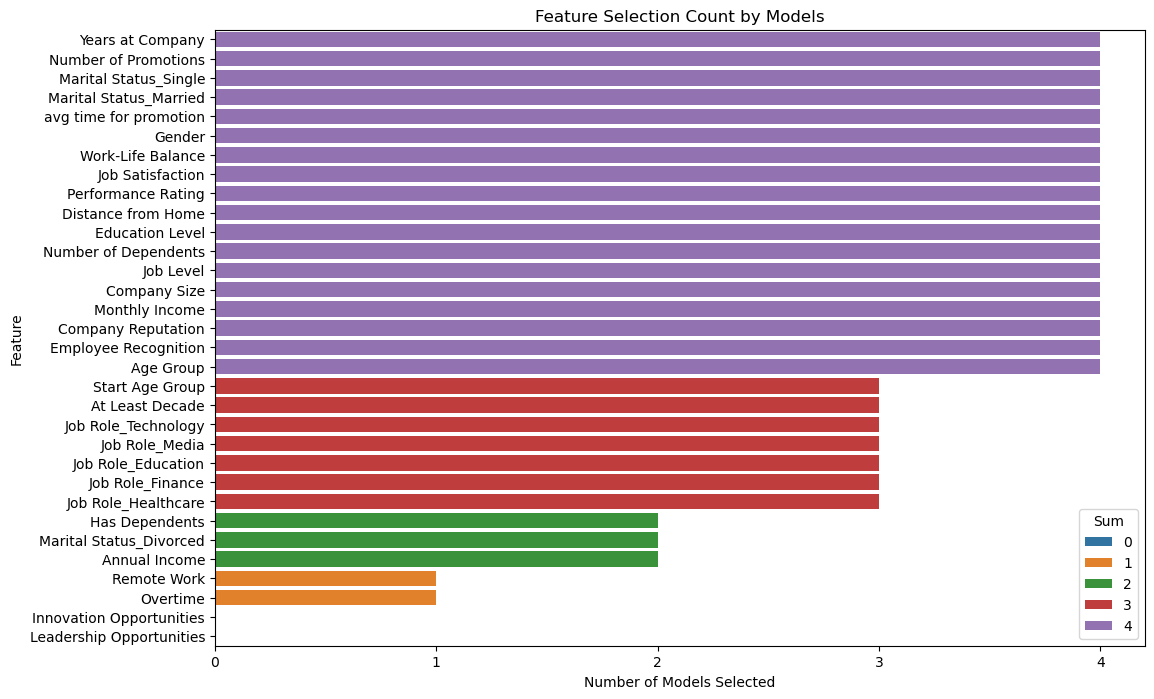

In [26]:
# Sort features by the sum of selections
selection_df_sorted = selection_df.sort_values(by="Sum", ascending=False)

# Create a discrete color palette based on the unique "Sum" values
unique_sums = selection_df_sorted["Sum"].nunique()
palette = sns.color_palette("tab10", unique_sums)  # Use 'tab10' or any other discrete colormap

# Map colors to unique Sum values
sum_colors = {val: palette[i] for i, val in enumerate(sorted(selection_df_sorted["Sum"].unique()))}

# Apply colors using the 'hue' parameter
plt.figure(figsize=(12, 8))
sns.barplot(
    data=selection_df_sorted,
    x="Sum",
    y="Feature",
    hue="Sum",  # Assigning hue to prevent warnings
    palette=sum_colors  # Use mapped colors for discrete sums
)

plt.xlabel("Number of Models Selected")
plt.ylabel("Feature")
plt.title("Feature Selection Count by Models")

# Set x-axis ticks to integer steps of 1
plt.xticks(range(selection_df_sorted["Sum"].min(), selection_df_sorted["Sum"].max() + 1, 1))

plt.show()

In [28]:
 #Selecting variables with a sum of selections >= 4
final_var = selection_df[selection_df['Sum'] >= 4]['Feature'].tolist()
filtered_df = X_final[final_var].copy()
filtered_df['Attrition'] = encoded_df['Attrition'].copy()

# Output the result to verify
filtered_df.columns.tolist()

['Years at Company',
 'Marital Status_Married',
 'Age Group',
 'Employee Recognition',
 'Company Reputation',
 'Monthly Income',
 'Company Size',
 'Job Level',
 'Number of Dependents',
 'Education Level',
 'Number of Promotions',
 'Performance Rating',
 'Job Satisfaction',
 'Work-Life Balance',
 'Gender',
 'avg time for promotion',
 'Distance from Home',
 'Marital Status_Single',
 'Attrition']

In [30]:
filtered_df.shape

(74498, 19)

After feature selection, we identified 19 important features out of 32, retaining only the most relevant predictors for our model.

### Save

In [32]:
folder = "data"
file_name = "filtered_employee_data"

save_file_as_pickle(filtered_df, folder, file_name)

File saved as: ../data/filtered_employee_data_20250326.pkl
